<a href="https://colab.research.google.com/github/urieliram/analog/blob/main/YuleWalker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

def AutoRegresion(serie, orden_fijo, orden_inf, orden_sup):
    minbic = 1.0e6
    vbics = []
    opor = orden_inf
    nd = (orden_inf + 1) * 2
    i = 0
    if orden_sup > len(serie) / 2:
        orden_sup = (len(serie) / 2) - 1
    if orden_inf > orden_sup:
        orden_inf = orden_sup
    if orden_fijo <= 0:
        vbics = [0] * (orden_sup - orden_inf + 1)
        opor = orden_inf
        nd = (orden_inf + 1) * 2
        minbic = 1.0e6
        i = 0
        for j in range(orden_inf, orden_sup + 1):
            nd = (j + 1) * 2
            vbics[i] = YuleWalkerAR(serie, nd, j, True)[0]
            if vbics[i] < minbic:
                minbic = vbics[i]
                opor = j
            i += 1
        print("Orden optimo: " + str(opor))
    else:
        opor = orden_fijo
        nd = (orden_fijo + 1) * 2
    return YuleWalkerAR(serie, nd, opor, False)

def YuleWalkerAR(serie, nd, orden, cbic):
    x = np.zeros(nd)
    for i in range(nd):
        x[i] = serie[i]
    mean = Mean(x, x.size)
    vari = Variance(x, mean, x.size)
    q = Autocorrelation(x)
    m = np.zeros((orden, orden))
    for i in range(orden):
        for j in range(orden):
            if i != j:
                m[i][j] = 0.0
            else:
                m[i][j] = vari * 1.0
    r = np.zeros((orden, 1))
    for i in range(orden):
        r[i][0] = vari * q[i + 1]
    for i in range(orden):
        for j in range(i + 1, orden):
            m[i][j] = vari * q[j - i]
            m[j][i] = vari * q[j - i]
    inv = MatrixInverse(m)
    fi = MatrixProduct(inv, r)
    if cbic:
        suma1 = 0.0
        c = np.zeros(orden + 1)
        for i in range(orden + 1):
            c[i] = vari * q[i]
            fip = -1
            if i > 0:
                fip = fi[i - 1][0]
            suma1 += fip * fip * c[0]
        suma2 = 0.0
        for i in range(1, orden + 1):
            sump = 0
            for k in range(orden - i):
                p1 = -1
                if k > 0:
                    p1 = fi[k - 1][0]
                sump += p1 * fi[i + k - 1][0]
            suma2 += sump * 2 * c[i]
        sa2 = suma1 + suma2
        nn = x.size
        BIC = math.log(sa2) + (orden + 1) * math.log(nn) / nn
        return np.array([BIC])
    else:
        phi = np.zeros(fi.size)
        for i in range(orden):
            phi[i] = fi[i][0]
        return phi

def Mean(x, nx):
    sum = 0
    for i in range(nx):
        sum += x[i]
    return sum / nx

def Variance(x, mean, nx):
    sum = 0
    for i in range(nx):
        sum += (x[i] - mean) * (x[i] - mean)
    return sum / nx

def Autocorrelation(x):
    mean = np.mean(x)
    autocorrelation = np.zeros(len(x)//2)
    na = len(autocorrelation)
    for t in range(na):
        n = 0
        d = 0
        for i in range(len(x)):
            xim = x[i] - mean
            n += xim * (x[(i+t)%len(x)] - mean)
            d += xim * xim
        autocorrelation[t] = n/d if d != 0 else 0
    return autocorrelation

def matrixCreate(rows, cols):
    result = np.zeros((rows, cols))
    return result

def MatrixInverse(matrix):
    n = len(matrix)
    result = matrixCreate(n, n)
    for i in range(n):
        for j in range(n):
            result[i][j] = matrix[i][j]
    lum, perm = matrixDecompose(matrix)
    b = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if i == perm[j]:
                b[j] = 1.0
            else:
                b[j] = 0.0
        x = helper(lum, b)
        for j in range(n):
            result[j][i] = x[j]
    return result

def matrixDecompose(m):
    n = len(m)
    toggle = 1
    lum = matrixCreate(n, n)
    for i in range(n):
        for j in range(n):
            lum[i][j] = m[i][j]
    perm = np.zeros(n)
    for i in range(n):
        perm[i] = i
    for j in range(n-1):
        max = abs(lum[j][j])
        piv = j
        for i in range(j+1, n):
            xij = abs(lum[i][j])
            if xij > max:
                max = xij
                piv = i
        if piv != j:
            tmp = lum[piv]
            lum[piv] = lum[j]
            lum[j] = tmp
            t = perm[piv]
            perm[piv] = perm[j]
            perm[j] = t
            toggle = -toggle
        xjj = lum[j][j]
        if xjj != 0.0:
            for i in range(j+1, n):
                xij = lum[i][j] / xjj
                lum[i][j] = xij
                for k in range(j+1, n):
                    lum[i][k] -= xij * lum[j][k]
    return lum, perm

def helper(luMatrix, b):
    n = len(luMatrix)
    x = b.copy()

    for i in range(1, n):
        sum = x[i]
        for j in range(0, i):
            sum -= luMatrix[i][j] * x[j]
        x[i] = sum

    x[n - 1] = 0 if luMatrix[n - 1][n - 1] == 0 else x[n - 1] / luMatrix[n - 1][n - 1]
    for i in range(n - 2, -1, -1):
        sum = x[i]
        for j in range(i + 1, n):
            sum -= luMatrix[i][j] * x[j]
        x[i] = 0 if luMatrix[i][i] == 0 else sum / luMatrix[i][i]
    return x

def matrixDeterminant(matrix):
    lum, _ = matrixDecompose(matrix)
    result = 1
    for i in range(len(lum)):
        result *= lum[i][i]
    return result

def MatrixProduct(matrixA, matrixB):
    aRows = len(matrixA)
    aCols = len(matrixA[0])
    bRows = len(matrixB)
    bCols = len(matrixB[0])
    if aCols != bRows:
        raise Exception("Non-conformable matrices")

    result = matrixCreate(aRows, bCols)

    for i in range(aRows):
        for j in range(bCols):
            for k in range(aCols):
                result[i][j] += matrixA[i][k] * matrixB[k][j]
    return result

def CalcularPronosticoARI(serie, n_pronosticos, orden_fijo, orden_inf, orden_sup):
    ultimo_valor = 0
    prono_diff = []
    prono_real = []
    serie_diff = []    
    serie_diff = DiferenciacionI(serie)
    prono_diff = CalcularPronosticoAR(serie_diff, n_pronosticos, orden_fijo, orden_inf, orden_sup)
    ultimo_valor = serie[len(serie)-1]
    prono_real = []
    for i in range(len(prono_diff)):
        ultimo_valor += prono_diff[i]
        prono_real.append(ultimo_valor)    
    return prono_real

def DiferenciacionI(serie):
    serie_diferenciada = []    
    for i in range(len(serie)-1):
        serie_diferenciada.append(serie[i+1]-serie[i])    
    return serie_diferenciada

def CalcularPronosticoAR(serie, n_pronosticos, orden_fijo, orden_inf, orden_sup):
    pron = 0
    media = np.mean(serie)
    serie_prep = serie - media
    sPron = np.zeros(n_pronosticos)
    phi = AutoRegresion(serie_prep, orden_fijo, orden_inf, orden_sup)
    v_serie = serie_prep.tolist()
    for i in range(n_pronosticos):
        pron = 0
        for j in range(len(phi)):
            pron += phi[j] * v_serie[len(v_serie) - j - 1]
        v_serie.append(pron)
        sPron[i] = pron + media
    return sPron

In [84]:
# Test
serie =[1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6]
n_pronosticos = 48
orden_fijo = -1
orden_inf = 2
orden_sup = 50

forecastAR  = CalcularPronosticoAR(serie, n_pronosticos, orden_fijo, orden_inf, orden_sup)
forecastARI = CalcularPronosticoARI(serie, n_pronosticos, orden_fijo, orden_inf, orden_sup)


Orden optimo: 48
Orden optimo: 8


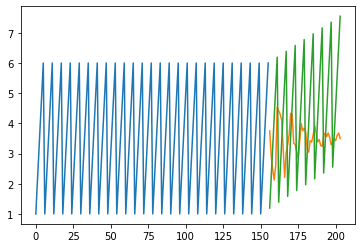

In [85]:
x = range(len(serie), len(serie)+len(forecastAR))
plt.plot(serie) 
plt.plot(x,forecastAR) 
plt.plot(x,forecastARI) 